In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Only do this once!
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.9 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=2057cf0c44030d5afab855fa98d75018e502395b8ce559407f2e3a03d238f039
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built pretrainedmodels


In [3]:
#Only do this once!
# !powershell -command "Expand-Archive C:\Users\alexa\Documents\GitHub\bridging_domain_gap\train_data\dataset_1000.zip C:\Users\alexa\Documents\GitHub\bridging_domain_gap\train_data\dataset_1000"
!unzip "/content/gdrive/MyDrive/train_data/dataset_1000.zip"

Archive:  /content/gdrive/MyDrive/train_data/dataset_1000.zip
 extracting: 000000.png              
 extracting: 000000_seg.png          
 extracting: 000000_ldmks.txt        
 extracting: 000001.png              
 extracting: 000001_seg.png          
 extracting: 000001_ldmks.txt        
 extracting: 000002.png              
 extracting: 000002_seg.png          
 extracting: 000002_ldmks.txt        
 extracting: 000003.png              
 extracting: 000003_seg.png          
 extracting: 000003_ldmks.txt        
 extracting: 000004.png              
 extracting: 000004_seg.png          
 extracting: 000004_ldmks.txt        
 extracting: 000005.png              
 extracting: 000005_seg.png          
 extracting: 000005_ldmks.txt        
 extracting: 000006.png              
 extracting: 000006_seg.png          
 extracting: 000006_ldmks.txt        
 extracting: 000007.png              
 extracting: 000007_seg.png          
 extracting: 000007_ldmks.txt        
 extracting: 000008.png   

In [4]:
#install weights and biases for data logging
!pip install wandb
!wandb login a4bcc50b82d76b731f260317595bd29e48e045a5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 16.0 MB/s 
     |████████████████████████████████| 168 kB 72.3 MB/s 
     |████████████████████████████████| 182 kB 74.3 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 168 kB 25.5 MB/s 
     |████████████████████████████████| 166 kB 61.1 MB/s 
     |████████████████████████████████| 166 kB 69.4 MB/s 
     |████████████████████████████████| 162 kB 70.2 MB/s 
     |████████████████████████████████| 162 kB 57.7 MB/s 
     |████████████████████████████████| 158 kB 92.3 MB/s 
     |████████████████████████████████| 157 kB 53.8 MB/s 
     |████████████████████████████████| 157 kB 54.8 MB/s 
     |████████████████████████████████| 157 kB 64.8 MB/s 
     |████████████████████████████████| 157 kB 84.1 MB/s 
     |████████████████████████████████| 157 kB 68.4 MB/s 
     |███████████████████████████

In [5]:
#time all processes to measure network efficiency
#only install once!
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 14.1 MB/s 
time: 378 µs (started: 2022-12-10 20:57:52 +00:00)


**Imports**

In [6]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pretrainedmodels
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as one
import matplotlib
from tqdm import tqdm
from torchvision import transforms
import wandb
import random
from PIL import Image, ImageFilter

time: 5.94 s (started: 2022-12-10 20:57:52 +00:00)


**Config**

In [7]:
#paths
# TEST_ROOT_PATH = "C:/Users/alexa/Documents/GitHub/bridging_domain_gap/300w/300W"
TEST_ROOT_PATH = '/content/gdrive/MyDrive/300W'
# TRAIN_ROOT_PATH = "C:/Users/alexa/Documents/GitHub/bridging_domain_gap/train_data/dataset_10000/dataset_10000"
TRAIN_ROOT_PATH = '/content'
# hyperparameters
BATCH_SIZE = 32 #could try smaller batch size. If model is still improving in last epoch this can be increased.
LR = 1e-3
EPOCHS = 70
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train/test split
TEST_SPLIT = 0.1 #for testing without training we want to test on most of the data
# show dataset keypoint plot
SHOW_DATASET_PLOT = True
RANDOM_SEED=42

time: 751 ms (started: 2022-12-10 20:57:58 +00:00)


**Augmentation**

In [8]:
class Config():
    def __init__(self):
        self.input_size = 244
        self.experiment_name = None

cfg = Config()
cfg.experiment_name = "01"

# Augmentation methods:
def random_translate(image, target, override = False):

    if override == True or random.random() > 0.75:
        image_height, image_width = image.size
        a = 1
        b = 0
        #c = 30 #left/right (i.e. 5/-5)
        c = int((random.random()-0.5) * 60)
        d = 0
        e = 1
        #f = 30 #up/down (i.e. 5/-5)
        f = int((random.random()-0.5) * 60)
        image = image.transform(image.size, Image.AFFINE, (a, b, c, d, e, f))
        target_translate = target.copy()
        target_translate = target_translate.reshape(-1, 2)
        target_translate[:, 0] -= 1.*c/image_width
        target_translate[:, 1] -= 1.*f/image_height
        target_translate = target_translate.flatten()
        target_translate[target_translate < 0] = 0
        target_translate[target_translate > 1] = 1
        return image, target_translate
    else:
        return image, target

def random_blur(image, override = False):
    if override == True or random.random() > 0.75:
        image = image.filter(ImageFilter.GaussianBlur(random.random()*5))
    return image


def random_occlusion(image, override = False):
    if override == True or random.random() > 0.75:
        image_np = np.array(image).astype(np.uint8)
        image_np = image_np[:,:,::-1]
        image_height, image_width, _ = image_np.shape
        occ_height = int(image_height*0.4*random.random())
        occ_width = int(image_width*0.4*random.random())
        occ_xmin = int((image_width - occ_width - 10) * random.random())
        occ_ymin = int((image_height - occ_height - 10) * random.random())
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 0] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 1] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 2] = int(random.random() * 255)
        image_pil = Image.fromarray(image_np[:,:,::-1].astype('uint8'), 'RGB')
        return image_pil
    else:
        return image

def random_rotate(image, target, angle_max, override = False):
    if override == True or random.random() > 0.75:
        center_x = 0.5
        center_y = 0.5
        landmark_num= int(len(target) / 2)
        target_center = np.array(target) - np.array([center_x, center_y]*landmark_num)
        target_center = target_center.reshape(landmark_num, 2)
        theta_max = np.radians(angle_max)
        theta = random.uniform(-theta_max, theta_max)
        angle = np.degrees(theta)
        image = image.rotate(angle)

        c, s = np.cos(theta), np.sin(theta)
        rot = np.array(((c,-s), (s, c)))
        target_center_rot = np.matmul(target_center, rot)
        target_rot = target_center_rot.reshape(landmark_num*2) + np.array([center_x, center_y]*landmark_num)
        return image, target_rot
    else:
        return image, target

time: 8.26 ms (started: 2022-12-10 20:57:59 +00:00)


**Utility**

In [9]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch=0):
    """
    This function plots the regressed (predicted) keypoints and the actual
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def image_keypoints_plot(image, keypoints):
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    keypoints = keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    keypoint = keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    keypoint = keypoint.reshape(-1, 2)
    for p in range(keypoint.shape[0]):
        plt.plot(keypoint[p, 0], keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact correct and the faces align with the keypoint features. The plot
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    plt.show()
    plt.close()


time: 5.21 ms (started: 2022-12-10 20:57:59 +00:00)


**Dataset Class**

In [10]:
def train_test_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples

def get_keypoints(file_name):
  #remove file extension from file_name
  idx = [idx for idx, x in enumerate(file_name) if x == '.']
  file_name = file_name[:idx[0]]
  #get name of keypoint file
  file_name = TRAIN_ROOT_PATH +  "/" + file_name + "_ldmks.txt"
  #fetch file and extract keypoints as list of tuples
  keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
  keypoints = np.array(keypoints, dtype='float32')
  return keypoints

class FaceKeypointTrainDataset(Dataset):
    def __init__(self, samples, path, training):
        self.data = samples
        self.path = path
        self.resize = 224
        #normalization required for pretrained pytorch networks
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([transforms.RandomGrayscale(0.2),
                                             transforms.Resize(cfg.input_size),
                                             transforms.ToTensor(),
                                             self.normalize])
        self.training = training

    def __len__(self):
        return len(self.data)

    def get_keypoints(self, file_name):
        #remove file extension from file_name
        idx = [idx for idx, x in enumerate(file_name) if x == '.']
        file_name = file_name[:idx[0]]
        #get name of keypoint file
        file_name = TRAIN_ROOT_PATH +  "/" + file_name + "_ldmks.txt"
        #fetch file and extract keypoints as list of tuples
        keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
        keypoints = np.array(keypoints, dtype='float32')
        return keypoints

    def __getitem__(self, index):
        # if self.training:
        if self.training:
          image = Image.open(f"{self.path}/{self.data[index]}").convert('RGB')
          orig_w, orig_h = image.size
          # get the keypoints
          keypoints = self.get_keypoints(self.data[index])
          #do keypoint preprocessing:
          keypoints = keypoints/512
          keypoints = np.reshape(keypoints, (keypoints.shape[0]*2, 1))
          keypoints = keypoints[:,0]
          # apply data augmentation
          #rotate image
          image, keypoints = random_rotate(image, keypoints, 30, True)
          keypoints = np.reshape(keypoints,(len(keypoints)//2, 2))
          #translate image
          image, keypoints = random_translate(image, keypoints, True)
          keypoints = np.reshape(keypoints,(len(keypoints)//2, 2))
          #add occlusion
          image = random_occlusion(image)
          #add blur
          image = random_blur(image)
          image = self.transform(image)
          # reshape the keypoints
          keypoints = keypoints.reshape(-1, 2)
          # rescale keypoints according to image resize
          keypoints = keypoints * [cfg.input_size, cfg.input_size]
        else:
          image = cv2.imread(f"{self.path}/{self.data[index]}")
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          orig_h, orig_w, channel = image.shape
          # resize the image into `resize` defined above
          image = cv2.resize(image, (self.resize, self.resize))
          # again reshape to add grayscale channel format
          image = image / 255.0
          # transpose for getting the channel size to index 0
          image = np.transpose(image, (2, 0, 1))
          image = torch.tensor(image, dtype=torch.float)
          image = self.normalize(image)
          # get the keypoints
          keypoints = self.get_keypoints(self.data[index])
          # reshape the keypoints
          keypoints = keypoints.reshape(-1, 2)
          # rescale keypoints according to image resize
          keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
        return {
            'image': image,
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

class FaceKeypointTestDataset(Dataset):
    def __init__(self, path):
      ind_names = np.array([])
      out_names = np.array([])
      for f in os.listdir(path + "/01_Indoor"):
        if not '.pts' in f:
          ind_names = np.append(ind_names, "/01_Indoor/" + f)
      for f in os.listdir(path + "/02_Outdoor"):
        if not '.pts' in f:
          out_names = np.append(out_names, '/02_Outdoor/' + f)
      self.ind_data = ind_names
      self.out_data = out_names
      self.path = path
      self.resize = 224
      #normalization required for pretrained pytorch networks
      self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.data)

    def get_300W_item(self, name):
      pathname = self.path + name
      image = cv2.imread(pathname)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      orig_h, orig_w, channel = image.shape
      # resize the image into `resize` defined above
      image = cv2.resize(image, (self.resize, self.resize))
      # again reshape to add grayscale channel format
      image = image / 255.0
      # transpose for getting the channel size to index 0
      image = np.transpose(image, (2, 0, 1))
      image = torch.tensor(image, dtype=torch.float)
      image = self.normalize(image)
      # get the keypoints
      idx = [idx for idx, x in enumerate(pathname) if x == '.']
      keyname = pathname[0:idx[0]] + ".pts"
      keypoints = np.loadtxt(keyname, dtype=float, comments=("version:", "n_points:", "{", "}"))
      # reshape the keypoints
      keypoints.reshape(68, 2)
      # rescale keypoints according to image resize
      keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
      return image, torch.tensor(keypoints,dtype=torch.float)

    def get_300W_Data(self):
      np.random.seed(RANDOM_SEED)
      np.random.shuffle(self.ind_data)
      np.random.shuffle(self.out_data)
      #use a randomized 500 ims from outdoor images and a randomized 500 from indoor images
      data = np.append(self.ind_data[0:500], self.out_data[0:500])
      return data

time: 7.94 ms (started: 2022-12-10 20:57:59 +00:00)


**Setup Data**

Training sample instances: 900
Validation sample instances: 100


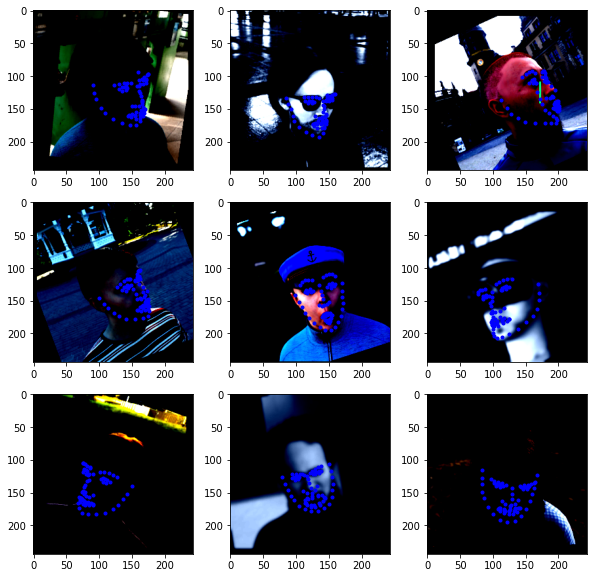

time: 2.27 s (started: 2022-12-10 20:57:59 +00:00)


In [11]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{TRAIN_ROOT_PATH}", TEST_SPLIT)
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointTrainDataset(training_samples, f"{TRAIN_ROOT_PATH}", training=True)
valid_data = FaceKeypointTrainDataset(valid_samples, f"{TRAIN_ROOT_PATH}", training=False)
# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
valid_loader = DataLoader(valid_data,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

# whether to show dataset keypoint plots
if SHOW_DATASET_PLOT:
    dataset_keypoints_plot(train_data)


In [12]:

# test data augmentation

# image_path = "000185.png"
# image = Image.open("/content/" + image_path)
# image = image.resize((cfg.input_size, cfg.input_size))

# orig_keypoints = get_keypoints(image_path)
# keypoints = orig_keypoints/512
# keypoints = np.reshape(keypoints, (keypoints.shape[0]*2, 1))
# keypoints = keypoints[:,0]

# image_augmented, target = random_rotate(image, keypoints, 30, True)
# target = np.reshape(target,(len(target)//2, 2))
# print(image_augmented)
# plt.imshow(image_augmented)
# plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
# plt.show()

# image_augmented, target = random_translate(image_augmented, target, True)
# target = np.reshape(target,(len(target)//2, 2))
# print(image_augmented)
# plt.imshow(image_augmented)
# plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
# plt.show()

# image_augmented = random_occlusion(image_augmented, True)
# print(image_augmented)
# plt.imshow(image_augmented)
# plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
# plt.show()

# image_augmented = random_blur(image_augmented, True)
# print(image_augmented)
# plt.imshow(image_augmented)
# plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
# plt.show()


time: 757 µs (started: 2022-12-10 20:58:02 +00:00)


**Model Class**

In [13]:
class FaceKeypointResNet50(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(FaceKeypointResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(2048, 140)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

time: 6.89 ms (started: 2022-12-10 20:58:02 +00:00)


**Training**

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training intermediate layer parameters...


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexmountain. Use `wandb login --relogin` to force relogin


Epoch 1 of 70
Training


29it [00:51,  1.78s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


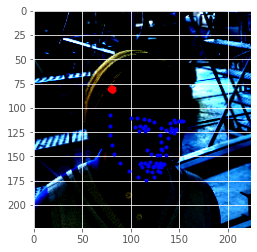

4it [00:03,  1.06it/s]


Train Loss: 13065.0251
Val Loss: 3052.9950
NME: 2.4697
Epoch 2 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


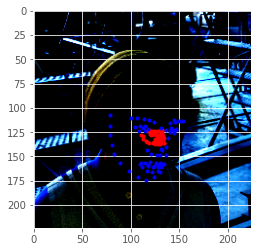

4it [00:03,  1.12it/s]


Train Loss: 3714.3268
Val Loss: 454.9109
NME: 0.8775
Epoch 3 of 70
Training


29it [00:43,  1.51s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


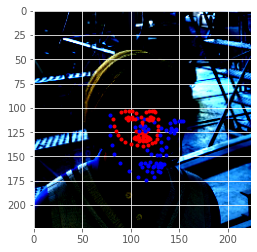

4it [00:03,  1.07it/s]


Train Loss: 719.0861
Val Loss: 447.7839
NME: 0.8783
Epoch 4 of 70
Training


29it [00:44,  1.53s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


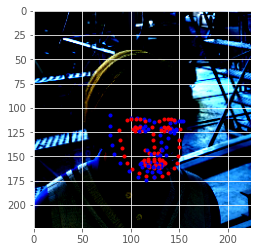

4it [00:03,  1.09it/s]


Train Loss: 402.0431
Val Loss: 323.4207
NME: 0.6878
Epoch 5 of 70
Training


29it [00:44,  1.53s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


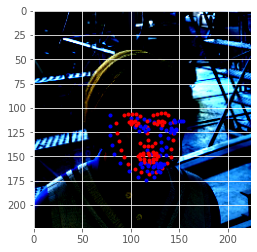

4it [00:03,  1.07it/s]


Train Loss: 380.0043
Val Loss: 306.6458
NME: 0.6233
Epoch 6 of 70
Training


29it [00:45,  1.56s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


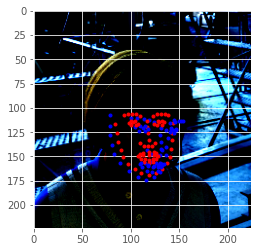

4it [00:03,  1.10it/s]


Train Loss: 389.0111
Val Loss: 313.2675
NME: 0.7803
Epoch 7 of 70
Training


29it [00:44,  1.52s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


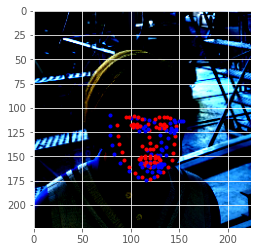

4it [00:03,  1.10it/s]


Train Loss: 357.8753
Val Loss: 294.8652
NME: 0.6991
Epoch 8 of 70
Training


29it [00:44,  1.54s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


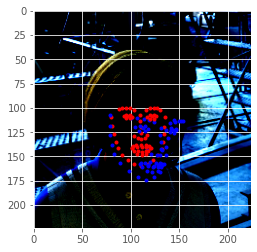

4it [00:03,  1.09it/s]


Train Loss: 352.0706
Val Loss: 378.1756
NME: 0.6926
Epoch 9 of 70
Training


29it [00:44,  1.53s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


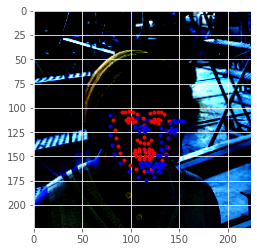

4it [00:03,  1.04it/s]


Train Loss: 360.2498
Val Loss: 319.8796
NME: 0.7197
Epoch 10 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


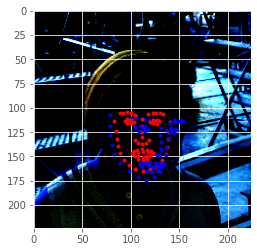

4it [00:03,  1.08it/s]


Train Loss: 320.5040
Val Loss: 220.2664
NME: 0.5325
Epoch 11 of 70
Training


29it [00:43,  1.52s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


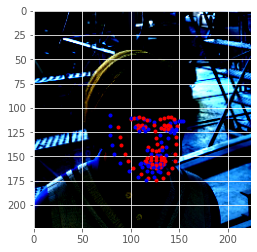

4it [00:03,  1.10it/s]


Train Loss: 244.7076
Val Loss: 131.4075
NME: 0.5580
Epoch 12 of 70
Training


29it [00:44,  1.52s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


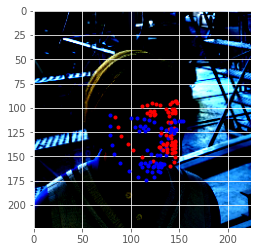

4it [00:03,  1.09it/s]


Train Loss: 201.6122
Val Loss: 404.4499
NME: 0.9756
Epoch 13 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


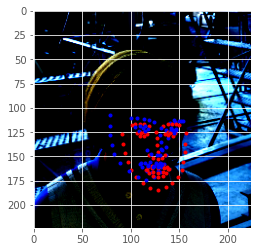

4it [00:03,  1.11it/s]


Train Loss: 198.0245
Val Loss: 230.5032
NME: 0.6250
Epoch 14 of 70
Training


29it [00:43,  1.51s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


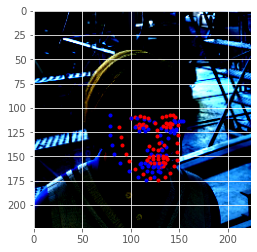

4it [00:03,  1.10it/s]


Train Loss: 161.5937
Val Loss: 192.7073
NME: 0.7358
Epoch 15 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


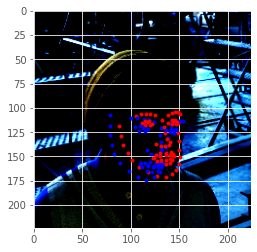

4it [00:03,  1.06it/s]


Train Loss: 155.1928
Val Loss: 442.8031
NME: 1.1925
Epoch 16 of 70
Training


29it [00:44,  1.54s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


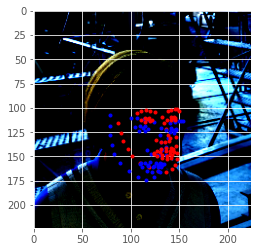

4it [00:03,  1.05it/s]


Train Loss: 161.7791
Val Loss: 220.7024
NME: 0.6749
Epoch 17 of 70
Training


29it [00:44,  1.52s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


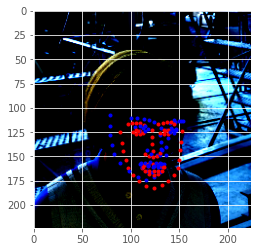

4it [00:03,  1.10it/s]


Train Loss: 173.1659
Val Loss: 233.6503
NME: 0.5993
Epoch 18 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


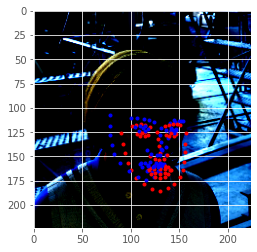

4it [00:03,  1.10it/s]


Train Loss: 145.8318
Val Loss: 597.3516
NME: 1.0796
Epoch 19 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


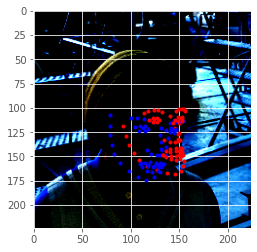

4it [00:03,  1.08it/s]


Train Loss: 156.3631
Val Loss: 269.8582
NME: 0.7212
Epoch 20 of 70
Training


29it [00:42,  1.48s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


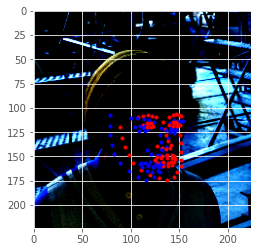

4it [00:03,  1.08it/s]


Train Loss: 136.4943
Val Loss: 148.0183
NME: 0.5197
Epoch 21 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


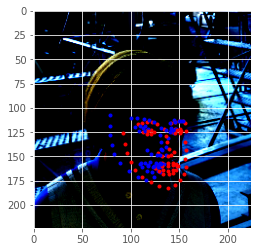

4it [00:03,  1.08it/s]


Train Loss: 156.6480
Val Loss: 381.1083
NME: 0.8844
Epoch 22 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


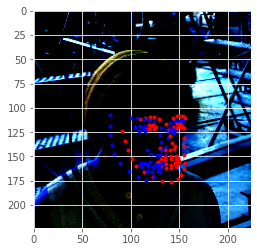

4it [00:03,  1.12it/s]


Train Loss: 135.3408
Val Loss: 166.3451
NME: 0.4608
Epoch 23 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


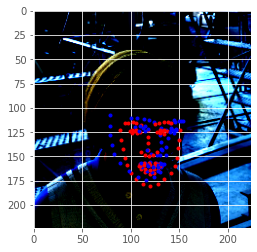

4it [00:03,  1.12it/s]


Train Loss: 124.5135
Val Loss: 96.6991
NME: 0.4558
Epoch 24 of 70
Training


29it [00:43,  1.51s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


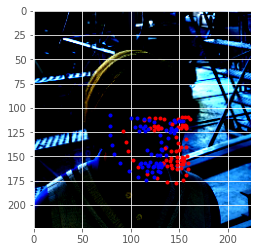

4it [00:03,  1.10it/s]


Train Loss: 125.7652
Val Loss: 331.9738
NME: 0.7999
Epoch 25 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


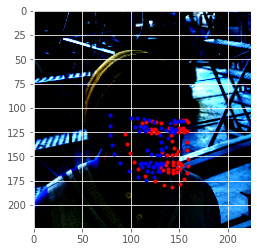

4it [00:03,  1.11it/s]


Train Loss: 111.5297
Val Loss: 307.3579
NME: 0.7452
Epoch 26 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


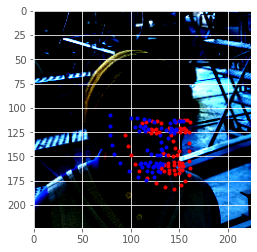

4it [00:03,  1.11it/s]


Train Loss: 104.1496
Val Loss: 315.1467
NME: 0.7473
Epoch 27 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


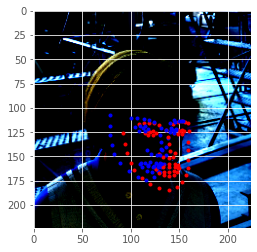

4it [00:03,  1.06it/s]


Train Loss: 107.0242
Val Loss: 180.1321
NME: 0.4862
Epoch 28 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


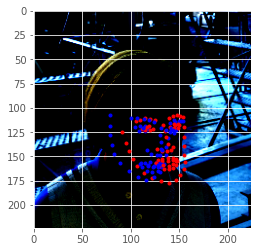

4it [00:03,  1.09it/s]


Train Loss: 104.8134
Val Loss: 147.2253
NME: 0.4106
Epoch 29 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


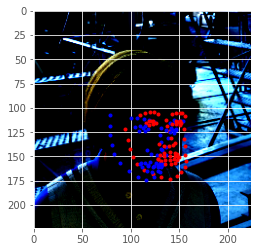

4it [00:03,  1.10it/s]


Train Loss: 95.2849
Val Loss: 145.2770
NME: 0.4576
Epoch 30 of 70
Training


29it [00:42,  1.48s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


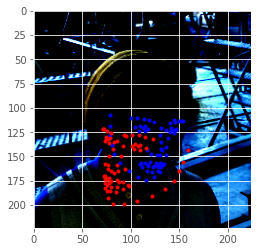

4it [00:03,  1.09it/s]


Train Loss: 140.1937
Val Loss: 522.6837
NME: 0.9772
Epoch 31 of 70
Training


29it [00:42,  1.48s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


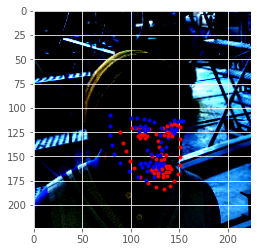

4it [00:03,  1.10it/s]


Train Loss: 182.3920
Val Loss: 206.0816
NME: 0.7333
Epoch 32 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


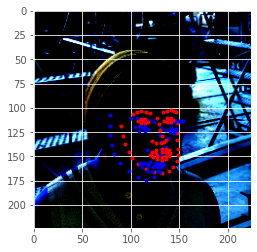

4it [00:03,  1.12it/s]


Train Loss: 128.6647
Val Loss: 133.7644
NME: 0.4704
Epoch 33 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


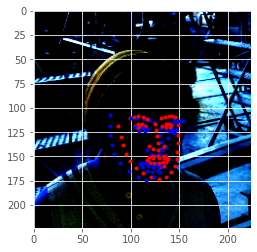

4it [00:03,  1.06it/s]


Train Loss: 117.1463
Val Loss: 160.3566
NME: 0.6779
Epoch 34 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


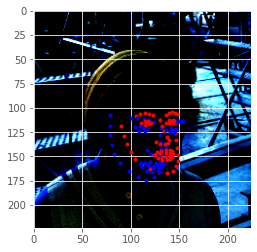

4it [00:03,  1.09it/s]


Train Loss: 99.4838
Val Loss: 228.9489
NME: 0.6356
Epoch 35 of 70
Training


29it [00:44,  1.52s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


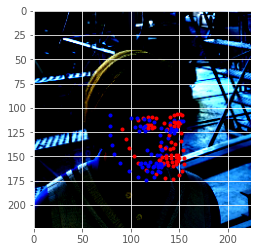

4it [00:03,  1.10it/s]


Train Loss: 109.5645
Val Loss: 178.7354
NME: 0.5634
Epoch 36 of 70
Training


29it [00:43,  1.51s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


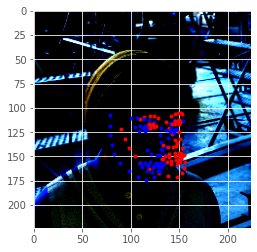

4it [00:03,  1.10it/s]


Train Loss: 92.0122
Val Loss: 424.5367
NME: 0.9821
Epoch 37 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


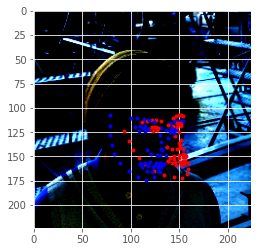

4it [00:03,  1.08it/s]


Train Loss: 84.8386
Val Loss: 627.7072
NME: 1.2278
Epoch 38 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


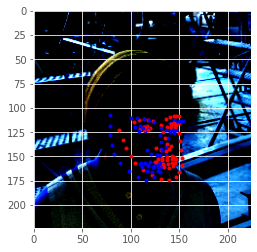

4it [00:03,  1.09it/s]


Train Loss: 94.6448
Val Loss: 154.6044
NME: 0.4932
Epoch 39 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


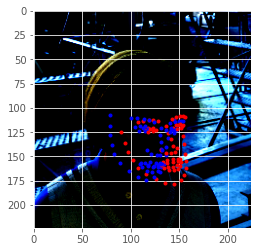

4it [00:03,  1.05it/s]


Train Loss: 86.8314
Val Loss: 279.8673
NME: 0.7771
Epoch 40 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


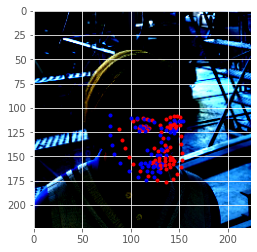

4it [00:03,  1.08it/s]


Train Loss: 71.6778
Val Loss: 113.5690
NME: 0.4272
Epoch 41 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


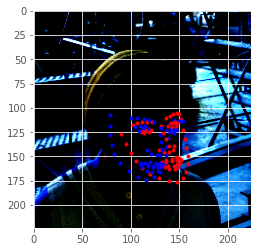

4it [00:03,  1.11it/s]


Train Loss: 69.4827
Val Loss: 293.5126
NME: 0.8110
Epoch 42 of 70
Training


29it [00:42,  1.48s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


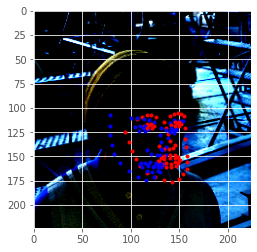

4it [00:03,  1.11it/s]


Train Loss: 65.2782
Val Loss: 209.6804
NME: 0.7494
Epoch 43 of 70
Training


29it [00:42,  1.48s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


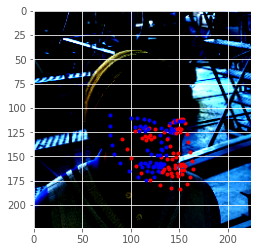

4it [00:03,  1.08it/s]


Train Loss: 70.4128
Val Loss: 506.7781
NME: 0.9705
Epoch 44 of 70
Training


29it [00:43,  1.51s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


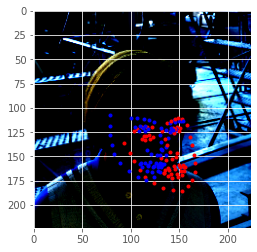

4it [00:03,  1.05it/s]


Train Loss: 63.6400
Val Loss: 335.8898
NME: 0.9795
Epoch 45 of 70
Training


29it [00:44,  1.52s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


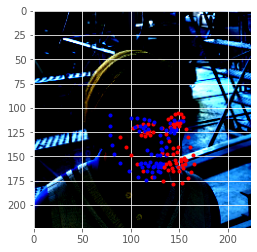

4it [00:03,  1.05it/s]


Train Loss: 67.4489
Val Loss: 494.7215
NME: 0.9651
Epoch 46 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


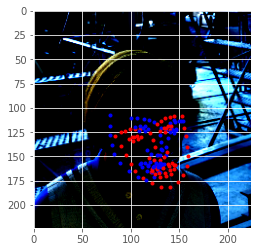

4it [00:03,  1.09it/s]


Train Loss: 62.4777
Val Loss: 176.6414
NME: 0.6639
Epoch 47 of 70
Training


29it [00:43,  1.51s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


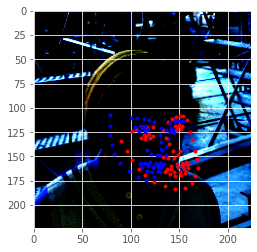

4it [00:03,  1.09it/s]


Train Loss: 66.8613
Val Loss: 306.6945
NME: 0.8889
Epoch 48 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


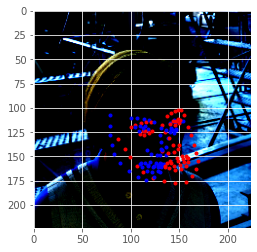

4it [00:03,  1.05it/s]


Train Loss: 64.5563
Val Loss: 511.7277
NME: 1.0997
Epoch 49 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


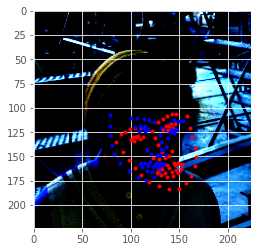

4it [00:03,  1.10it/s]


Train Loss: 59.3737
Val Loss: 331.9139
NME: 0.7173
Epoch 50 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


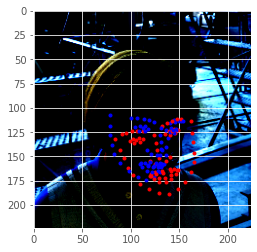

4it [00:03,  1.08it/s]


Train Loss: 58.2602
Val Loss: 187.2821
NME: 0.6051
Epoch 51 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


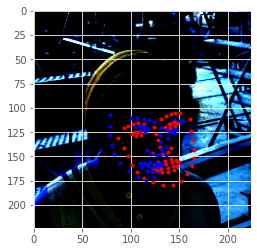

4it [00:03,  1.03it/s]


Train Loss: 45.5521
Val Loss: 274.2448
NME: 0.7754
Epoch 52 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


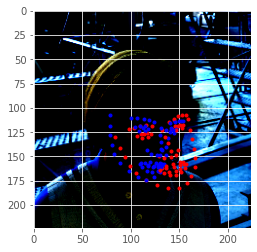

4it [00:03,  1.07it/s]


Train Loss: 59.0760
Val Loss: 387.3098
NME: 0.9813
Epoch 53 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


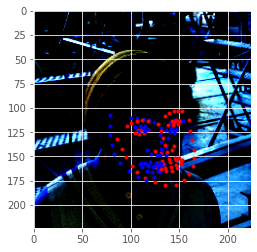

4it [00:03,  1.06it/s]


Train Loss: 49.8691
Val Loss: 258.3766
NME: 0.7303
Epoch 54 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


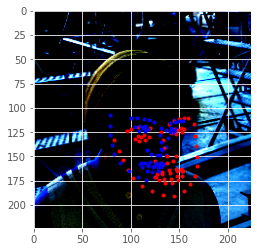

4it [00:03,  1.10it/s]


Train Loss: 58.9830
Val Loss: 230.5692
NME: 0.6725
Epoch 55 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


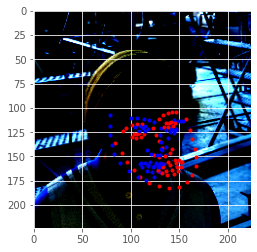

4it [00:03,  1.09it/s]


Train Loss: 78.7579
Val Loss: 321.1550
NME: 0.8759
Epoch 56 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


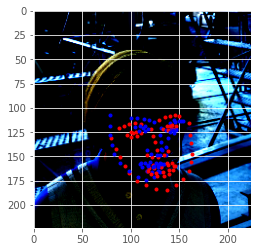

4it [00:03,  1.07it/s]


Train Loss: 56.0777
Val Loss: 199.4932
NME: 0.6064
Epoch 57 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


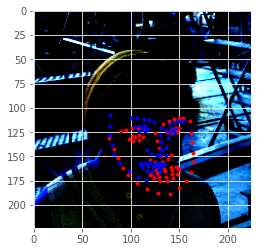

4it [00:03,  1.05it/s]


Train Loss: 45.8363
Val Loss: 228.3849
NME: 0.5917
Epoch 58 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


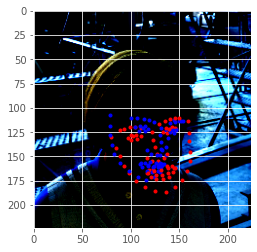

4it [00:03,  1.08it/s]


Train Loss: 46.7673
Val Loss: 154.2355
NME: 0.4921
Epoch 59 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


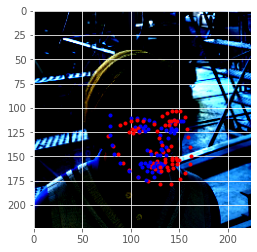

4it [00:03,  1.09it/s]


Train Loss: 48.0324
Val Loss: 155.5745
NME: 0.5030
Epoch 60 of 70
Training


29it [00:43,  1.51s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


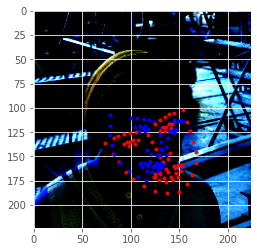

4it [00:03,  1.09it/s]


Train Loss: 40.1720
Val Loss: 251.1830
NME: 0.6585
Epoch 61 of 70
Training


29it [00:43,  1.48s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


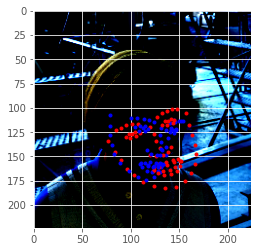

4it [00:03,  1.05it/s]


Train Loss: 46.8669
Val Loss: 190.2695
NME: 0.5345
Epoch 62 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


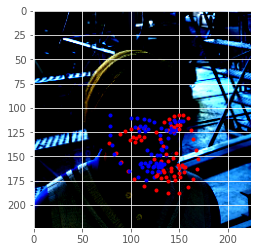

4it [00:03,  1.08it/s]


Train Loss: 41.3518
Val Loss: 229.2164
NME: 0.6633
Epoch 63 of 70
Training


29it [00:44,  1.54s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


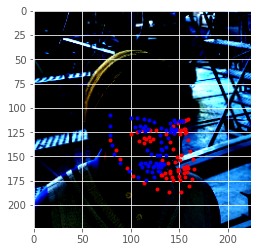

4it [00:03,  1.03it/s]


Train Loss: 43.3675
Val Loss: 670.0505
NME: 1.2026
Epoch 64 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


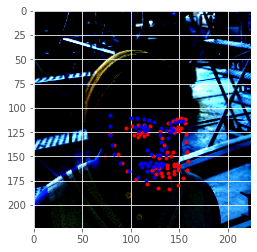

4it [00:03,  1.07it/s]


Train Loss: 37.8429
Val Loss: 293.4162
NME: 0.7076
Epoch 65 of 70
Training


29it [00:43,  1.51s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


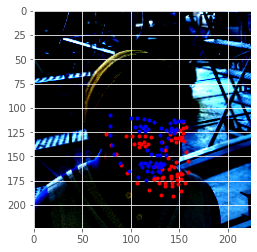

4it [00:03,  1.08it/s]


Train Loss: 56.6660
Val Loss: 327.6570
NME: 0.8007
Epoch 66 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


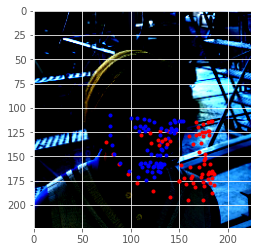

4it [00:03,  1.08it/s]


Train Loss: 69.1184
Val Loss: 970.9915
NME: 1.4708
Epoch 67 of 70
Training


29it [00:43,  1.49s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


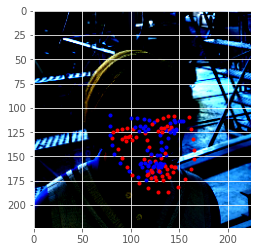

4it [00:03,  1.06it/s]


Train Loss: 62.3230
Val Loss: 205.4191
NME: 0.6530
Epoch 68 of 70
Training


29it [00:43,  1.51s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


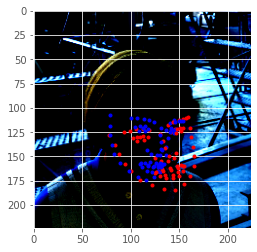

4it [00:03,  1.08it/s]


Train Loss: 72.6594
Val Loss: 359.6287
NME: 0.7907
Epoch 69 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


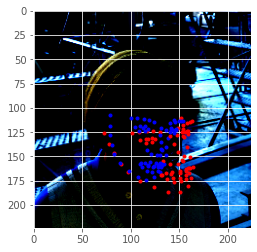

4it [00:03,  1.01it/s]


Train Loss: 77.1989
Val Loss: 516.6274
NME: 0.8183
Epoch 70 of 70
Training


29it [00:43,  1.50s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


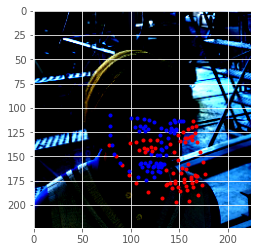

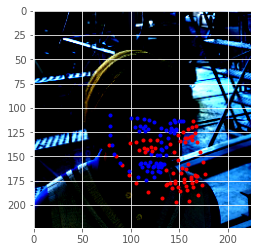

 33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


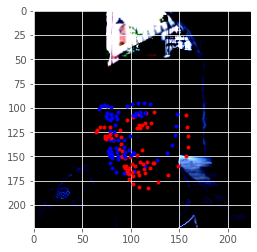

 67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


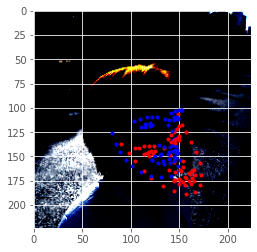

100%|██████████| 3/3 [00:04<00:00,  1.31s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


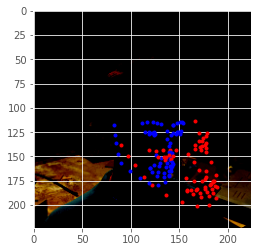

4it [00:04,  1.24s/it]


Train Loss: 62.0138
Val Loss: 472.6703
NME: 1.0671


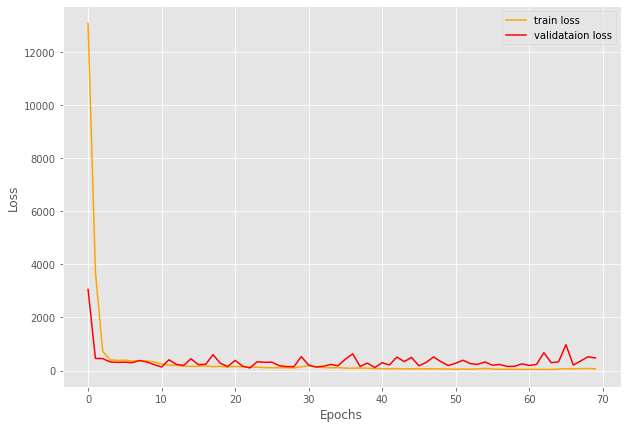

DONE TRAINING
time: 55min 48s (started: 2022-12-10 20:58:02 +00:00)


In [14]:
def compute_nme(preds, target):
    """ preds/target:: numpy array, shape is (N, L, 2)
        N: batchsize L: num of landmark
    """
    preds = preds.cuda().detach().cpu().clone().numpy()
    target = target.cuda().detach().cpu().clone().numpy()

    preds = preds[:, 0:136]

    N = preds.shape[0]
    preds = np.reshape(preds, (N, 68, 2))
    L = preds.shape[1]
    L_targ = target.shape[1]

    if L_targ == 140:
      target = target[:, 0:136]
    target = np.reshape(target, (N, 68, 2))

    rmse = np.zeros(N)

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        if L == 68:  # 300w
            # interocular
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])
        else:
            raise ValueError('Number of landmarks is wrong')
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt,
                                        axis=1)) / (interocular * L)

    return np.mean(rmse)

matplotlib.style.use('ggplot')
#model
#NOTE: setting pretrained=True and requires_grad=True initializes our weights with pretrained model and then updates our intermediate layers
model = FaceKeypointResNet50(pretrained=True, requires_grad=True).to(DEVICE)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmoothL1Loss ...
# ... or MSELoss
criterion = nn.MSELoss()

# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss/counter
    return train_loss

# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            nme = compute_nme(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs\
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
            if epoch+1 == EPOCHS:
                valid_keypoints_plot(image, outputs, keypoints, epoch)

    valid_loss = valid_running_loss/counter
    return valid_loss, nme

# Do training and validation

wandb.init(project="resnet50_domain_gap")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
wandb.watch(model, criterion, log="all", log_freq=1) #TODO might want to change log_freq?

best_val_loss = 1000
# Want to test without training: do validation for a small number of epochs
train_loss = []
val_loss = []
nme = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss, nme_val = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    nme.append(nme_val)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f'NME: {nme_val:.4f}')
    wandb.log({"epoch": (epoch+1),
               "train_loss": (train_epoch_loss),
               "val_loss": (val_epoch_loss),
               "NME": (nme_val)})
    wandb.define_metric("epoch")
    # if val_epoch_loss < best_val_loss:
    #   best_val_loss = val_epoch_loss
    #   torch.save({
    #         'epoch': EPOCHS,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': criterion,
    #         }, 'C:/Users/alexa/Documents/GitHub/bridging_domain_gap/resnet50_10000_fully_aug.pt')
    if val_epoch_loss < best_val_loss:
      best_val_loss = val_epoch_loss
      torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '/content/gdrive/MyDrive/train_data/resnet50_1000_best.pt')


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
# plt.plot(nme, color='blue', label='NME')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('DONE TRAINING')


**Testing Phase**

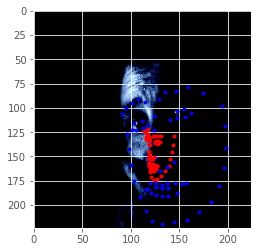

0.5067165059521282
0.4193396555304015
4.198308402905442
2.968203111494979
0.42810570924145425
3.176020820898871
13.84806940914182
26.0734467853614
1.8542644215672397
2.0321797908377937
0.3968312019398736
6.885517640584737
1.09080798629268
0.6078097776053996
4.01097932694795
1.2716369378023848
1.475293353282339
4.374621327128199
20.233752640832233
12.080188478085539


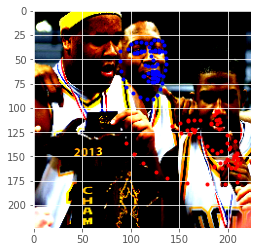

3.66083669994557
17.140776177289673
0.29923318563985796
0.4144269395481403
14.576282527632133
0.25344349173593833
0.46995572728210766
0.71705888519104
37.87104808017854
9.295094984202292
0.5302092832819422
5.5545917749813185
0.400163877383141
7.000885291951187
4.14525000772034
21.42627455668444
9.250446098662822
14.172945505014225
3.0702226277454128
3.3764398474713415


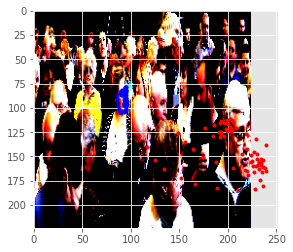

19.28170860603867
3.6541273297415944
0.7542114941590456
0.5688505530112243
4.1799938020582355
2.6451095843707026
1.4582958573208407
0.6058461010292222
10.089565696062872
0.3511292444029201
17.041663563719602
37.62006200702053
3.7171717682972782
1.634499223362681
0.41435447936014114
0.7507090056614432
8.34319754625715
16.770218503130735
11.325609280108864
3.188005524457702


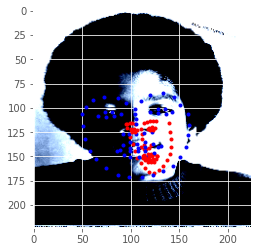

0.3019571752598456
1.6742283475721251
4.129236692532035
1.4876617076894627
0.8412802578534524
0.5739556073058694
0.3583909165256075
0.7292573176739607
4.726729783748721
0.30040599363777165
27.198055236530262
15.161063595799003
2.2708636985057926
12.222323633332131
9.9582951207393
0.23661555845936336
2.253360098104139
3.8939083038733164
4.986818862604922
0.8268871794035116


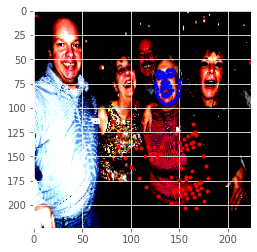

5.9278106765885505
18.638075056365263
0.2787674058669235
23.06631732902495
5.4727637337872075
8.934258621677163
13.592425063005813
3.1640431292512443
0.8225212472483072
5.470044669755207
2.265502251082488
15.521417866074117
2.6155663050497333
1.1633916723022604
5.188524836282072
0.6918095389458143
12.960588081554132
14.28458458097953
2.1614186846413284
5.194205695475607


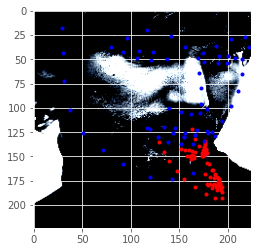

0.7484472663702758
11.402888305696752
0.5002731862864936
0.7353358602142339
1.9313863842129826
0.6670271302420009
8.061949240306243
2.622776100242042
5.49409055015291
22.623279015042947
1.3615928171007288
3.489535290523615
0.9945118825561962
0.47402821266024253
0.44442249344668566
6.6502639403554396
15.286553808704436
0.647920349336603
8.416218553418686
0.7715960825188317


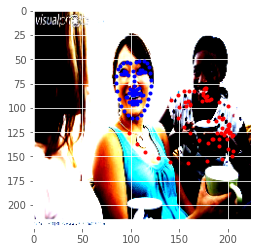

3.3593245574835753
1.4799418549643646
5.363932917797752
6.22811580106207
10.473604914261992
1.003534601032205
1.022527253264591
24.24481717245132
11.659506465755278
0.3989109391190522
8.290818384431393
8.984812955197732
5.2822923222338165
6.458148826007836
1.4226662025844272
0.293385435170234
1.5800165005380173
0.8099756475489698
1.3293545968011151
6.307396569817274


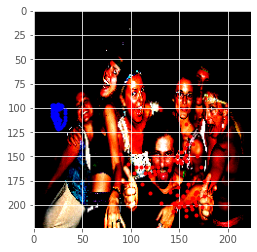

16.30662024279773
11.85588728125214
0.8614610331616038
4.740870195880287
0.3573187021126999
5.177921326699446
15.968752764869043
5.774947562444243
0.49219403782607407
0.36710463893423695
0.3909145586767085
20.66125494752364
1.2406432982695523
3.9871631327364048
0.44696862307429897
0.9726374998898185
0.8450669190075198
0.3925660035146017
10.578681428195713
0.5651847294831375


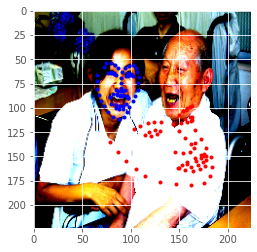

3.3467187746388443
13.171739064168301
2.601699715887739
1.7995923611690656
0.7674856769757107
24.86043252453435
0.3234654714276331
0.5150914763450177
1.4816481818624334
11.680001647408135
4.541527006595822
0.35831453452861384
0.5045507460887164
0.6155438687221282
14.376491196932644
3.2916727798580565
3.0952644207697895
6.02587358138392
0.34138190533682994
12.231080160185849


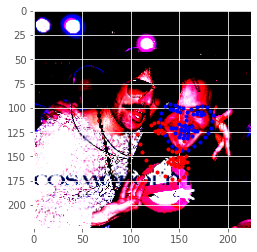

0.8240618282353896
4.016782316368599
1.816469056989537
0.561004791113733
4.960959258384753
2.1171708481799003
0.4641404868663968
0.905490195851713
15.215489863886177
0.4471529775953669
0.388146200065221
4.000183772886404
11.091818409331362
0.8879676289209217
0.6477739955065283
4.361415833202115
0.7290784931742538
0.3995652788052454
2.571016252401408
2.968284951785227


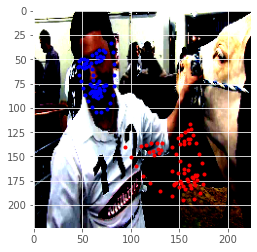

5.118018134370207
6.365467447589358
1.4096421772888474
0.7012304160838796
7.527986232024354
0.6483895769821232
0.8342626205882444
4.855912122113442
0.7816883476402176
2.4547613914815254
12.544036643217327
0.2856296855591049
1.642791240924515
12.431468048707488
0.7914969398996451
2.0963234250475025
0.39805529902091197
0.5501463321801079
2.366112275041855
0.756138550502032


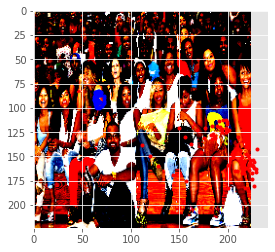

25.25952353435525
1.2212674139113753
0.9817706474030318
2.881726472472272
3.5283054515227734
0.6398992346393884
9.754500364712733
7.627912198688263
0.7594986187394854
2.998257393885869
0.3840782176274441
0.35517813521896646
1.1981207322072847
4.704017157696942
1.7911328803530904
0.3134489511603512
0.4867224794052321
14.876063718662945
4.217359127882309
0.31982525810283674


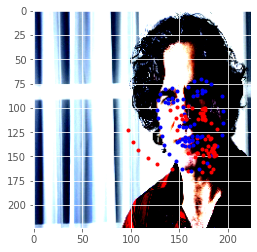

0.5957042578596904
0.4148097402017956
10.418164924115645
0.7551825862184618
0.9463989991233762
16.887896363514255
1.8934193764894625
0.3176790093327232
1.1571273414627716
4.626013922822941
15.120292731738287
6.33851735017385
0.6035245083106386
0.7466358066052898
0.25856650499433786
8.505309148764123
0.588754698027613
1.2597202563376309
0.3739778169731168
0.414712138998933


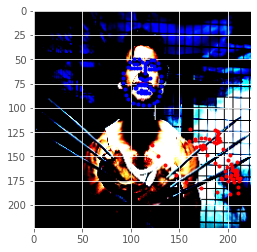

4.320651308006821
5.88811335482057
0.3582607003694601
0.7919920161585617
8.42004726438741
4.1042646438584445
0.5133914230835736
0.45766680334059484
5.069341576768773
0.5858777115794054
2.2232618794283456
9.469737971920267
0.32772770433219056
12.56924245924617
0.6176978068106612
6.587140339917901
0.6982736516010194
2.9387653596467156
3.4519110896309146
0.5992367177859562


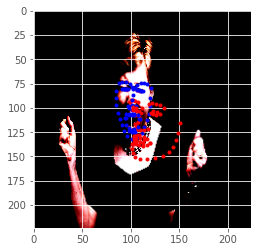

1.1723263246010793
0.38382498749078925
10.952488832790698
0.47491232126297767
8.70285671996334
0.7270244609326248
2.85736814218745
10.650797113609666
5.896896587202072
3.490641602750143
14.707512902211462
0.7472979929789537
9.526131153592369
3.697007584588871
2.1177659526236634
5.859159311934847
11.61883823788933
12.106171560838597
1.0985443812375908
13.995184199267344


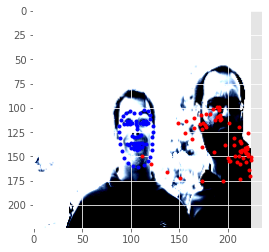

3.4808306978922063
6.2158773917706185
1.8831503121523587
4.906842944996252
10.84581430644217
0.31440310573153646
7.08180372343036
1.3125874795230061
4.804948597569405
3.075216065432065
1.4394290025277023
4.070657533238121
16.516510050773373
9.392004285018896
16.54690943897371
2.681786201012524
1.1058151096320497
4.992969939952715
18.027924460686695
2.9460022649359496


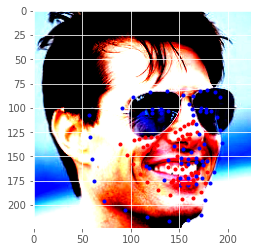

0.4030959198763601
7.0100594996361565
10.501155958719318
0.41521338514265416
0.8734428518146836
34.342248218665105
0.8377466219022655
0.9431973802176111
0.7208931614322182
26.56986676620111
3.530092445209907
11.559102360839132
1.2766806155643244
21.455969273992498
13.323624728067701
5.4820584949927
0.6377560706692146
8.645792125003123
0.553269326954545
3.449030734520486


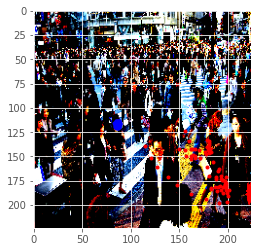

30.83151051586668
4.206911447413979
11.046037504532556
2.2231166890836307
4.330719208388771
13.40372924933915
1.0773858121317463
13.887545786864056
1.5271337696626202
3.75284662714664
0.2786251447035496
1.0681726109375158
4.515868740457354
1.9504376115391604
15.634558787119769
0.8839225095798335
2.4629548078231873
14.125374076255321
2.465714578432221
25.984518151615916


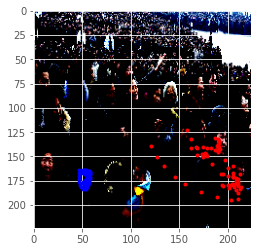

20.991995225099203
5.106974134035135
9.342386667196442
0.49032676890528737
4.75449850953027
27.87516328970253
4.305522619765198
0.46844752134078266
1.2091646858307914
42.09655921877532
11.589205218173461
14.230398812491783
2.179778207738028
26.1718352011942
5.418756686357431
2.0989319680282885
2.836140538020459
6.939298033561311
1.9814566833622158
6.206287177471307


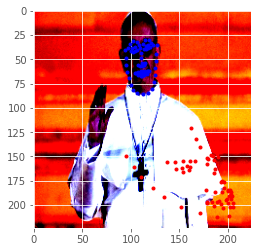

6.9184933589569795
1.026388023343847
2.1546953362496857
3.1592917747929863
14.490749977256483
6.884094379719036
0.443616756924583
4.962591961979748
10.455225392837312
0.37261787939111657
10.962169137263933
7.931993981143177
7.450343347778272
6.265421526115701
16.688489864285515
9.125616436781606
5.989260066825894
6.791808272046534
8.359615132404908
9.94875187582999


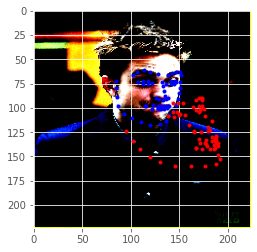

1.356098142741592
18.73071038257723
0.4428875555278825
1.7786179521774554
0.5521374335027478
0.718052321195416
1.0726681149652872
3.8700495959176173
3.5525163711201726
3.6065927952806986
0.7496464648545548
5.650818274592474
9.14195478192812
3.684008633073374
0.44256448856439645
20.56685613619615
6.541475604420725
0.5552284206096757
10.355100647292582
2.2279800988517566


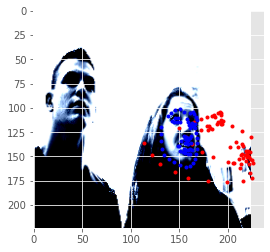

1.716576730901519
7.391147319638786
12.466045645463176
6.878722103592334
4.437080402430029
15.608313173305392
1.243912433508736
11.93070081364003
4.317810041993495
0.8778345278392071
7.244811755550702
20.527680366928983
7.084523757465494
6.165190179938852
26.80073221510762
0.27889787342485534
4.259423404316208
11.104961783575233
0.3906499729111456
2.9637044194380984


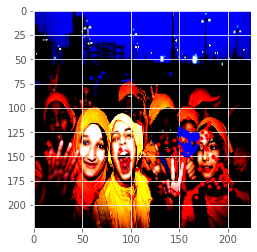

2.4591598010196534
24.93750603488291
0.8473468193482243
7.474003225174303
1.0874018493002873
6.312440508486862
20.537212476877144
11.747688288124326
9.989444905280122
1.9488375302308625
1.3808746213552068
0.9984177000210883
13.850657958822048
12.633425411811041
3.46353750089666
2.244479480550712
9.634929219926988
4.686007818821564
2.8669652322938495
7.974924027795852


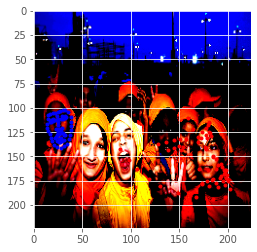

8.63732984637962
12.096289537107346
0.6372294261026287
3.3076378493048515
4.713380180332933
16.2917551321462
7.817914824293932
3.4448367715875525
2.9579855469719107
26.36912029571741
9.403147305658543
25.199391589565113
12.456161725659047
0.6768687044415201
12.261532351216744
8.944844459875636
1.6143278510432355
14.640403061262335
0.8407108129778186
10.83842938789181


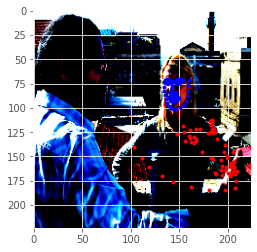

4.922109800150866
11.45572265174566
5.357753149514036
21.000415601498833
1.7593413529738746
9.282692197939424
15.584452239949417
4.0057076753184315
0.6164381679374182
3.116684895221084
0.41733155422241436
0.4024910637014362
4.557136713805246
3.2721748103936066
5.448991711074187
0.5683824951418337
0.5948618992287216
11.035987919826104
21.902225289385367
1.1539615973213946


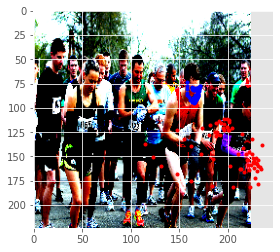

9.948311473720228
16.589303104681054
15.967264144113235
30.199892259269642
5.22623991717499
0.24429530616297349
0.2925480197479224
11.544966081359789
5.124224533807231
1.4531332255633782
0.7101506297975949
8.648159230841731
4.972614995275678
3.917096472325624
19.04232077549382
1.0704950729825276
0.6446483015056413
2.970649632343232
20.496112133526335
1.201248533886182


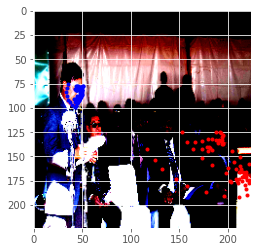

23.3263461131185
4.337672938085366
12.861814565452756
3.905634673156501
0.23977267542739084
6.066247778623538
3.1318744557600193
2.333593863408747
2.4243764806064316
6.0264780088193834
33.64443322008804
5.703438139701839
19.062967615071393
1.207017229256759
20.036928706237124
5.640783767996313
16.065266968195235
22.896174616560046
1.6982396443527392
7.54764896564479


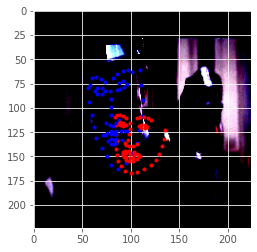

1.0492879244699238
2.014378413407529
16.98972393787978
4.307922996985683
1.0243988801021662
13.522344602849314
9.53854861095168
2.67816261136976
20.286547857996126
8.076898422527076
1.9074455177595018
0.9288043009994613
2.710856497596574
7.351905542249674
12.207866516743245
4.021625672779249
0.3923713260733937
2.8118523750196127
1.4616222028653327
13.08935500729827


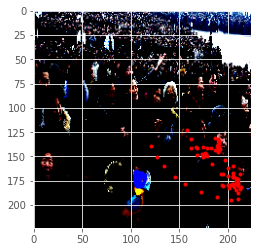

12.51112580602477
10.763164738842214
9.333282191787328
26.985822003515445
4.1483923074022755
1.5196458436786242
3.529377387226154
0.4279755947538783
2.0258650255169393
1.5843669980485535
3.22221903192685
11.740060356366321
0.8342034761232123
3.5367352527889673
3.085369789431337
18.396874435945993
16.32245774187792
0.2544486180626939
3.3191404581557777
5.271133595211149


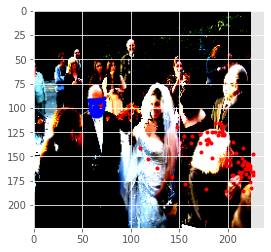

16.844776048136296
5.925875935598314
9.00281151544731
0.44995741550646673
17.765579451742255
0.516110521790952
7.899832583840915
2.9522626620220302
0.768337513987839
8.808264982045026
3.632783478457137
2.700550110581003
2.062189150054178
12.481641521183427
52.34466837994776
16.496600585122955
0.3097289239463885
5.171880191780817
0.7002774901858316
11.478155092205908
Average NME: 6.333902876245033
time: 12min 42s (started: 2022-12-10 21:53:50 +00:00)


In [15]:
#Run model on test data from 300WLPA dataset and report NME

#model.load_state_dict(torch.load('sample_data/resnet50_1000.pt')['model_state_dict'])
testdata = FaceKeypointTestDataset(TEST_ROOT_PATH)
dataframe = testdata.get_300W_Data()
nme = []
count = 0
for n in dataframe:
  image, keypoints = testdata.get_300W_item(n)
  image = torch.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  image = image.to(DEVICE)
  keypoints = torch.reshape(keypoints, (1, keypoints.shape[0], keypoints.shape[1]))
  outputs = model(image)
  outputs = outputs[:, 0:136]
  if count % 20 == 0:
    valid_keypoints_plot(image, outputs, keypoints)
  nme_val = compute_nme(outputs, keypoints)
  print(nme_val)
  nme.append(nme_val)
  count += 1


nme = np.array(nme)
print("Average NME: " + str(np.mean(nme)))

**Video Integration**

If this doesn't work in colab then run it locally by downloading the model after training

(download will take a while unfortunately).

You will also require the above code that handles hyperparameter configuration and the code that defines our model class

In [16]:
# #Imports required for running video locally:
# import torch
# import torch.nn as nn
# import numpy as np
# import cv2
# from torchvision import transforms
# import pretrainedmodels

time: 837 µs (started: 2022-12-10 22:06:32 +00:00)


In [17]:
# model = FaceKeypointResNet50(pretrained=False, requires_grad=False).to(DEVICE)
# # checkpoint = torch.load('sample_data/my_model_1000.pt')
# # model.load_state_dict(checkpoint['model_state_dict'])
# # model.eval()

# #capture the webcam
# cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
# if cap.isOpened()==False:
#   print('Error while trying to open webcam. Please check again...')

# # get the frame width and height
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))

# # set up the save file path
# save_path = "sample_data/vid_keypoint_detection.mp4"
# # define codec and create VideoWriter object
# out = cv2.VideoWriter(f"{save_path}",
#                       cv2.VideoWriter_fourcc(*'mp4v'), 20,
#                       (frame_width, frame_height))
# norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# while(cap.isOpened()):
#     # capture each frame of the video
#     ret, frame = cap.read()
#     if ret == True:
#         with torch.no_grad():
#             image = frame
#             image = cv2.resize(image, (224, 224))
#             orig_frame = image.copy()
#             orig_h, orig_w, c = orig_frame.shape
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             image = image / 255.0
#             image = np.transpose(image, (2, 0, 1))
#             image = torch.tensor(image, dtype=torch.float)
#             image = norm(image)
#             image = image.unsqueeze(0).to(DEVICE)
#             outputs = model(image)
#         outputs = outputs.cpu().detach().numpy()
#         outputs = outputs.reshape(-1, 2)
#         keypoints = outputs
#         for p in range(keypoints.shape[0]):
#             cv2.circle(orig_frame, (int(keypoints[p, 0]), int(keypoints[p, 1])),
#                         1, (0, 0, 255), -1, cv2.LINE_AA)
#         orig_frame = cv2.resize(orig_frame, (frame_width, frame_height))
#         cv2.imshow('Facial Keypoint Frame', orig_frame)
#         out.write(orig_frame)
#         # press `q` to exit
#         if cv2.waitKey(27) & 0xFF == ord('q'):
#             break

#     else:
#         break

time: 2.37 ms (started: 2022-12-10 22:06:32 +00:00)
